In [2]:
%matplotlib inline

This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

The core model is an GRU/LSTM.

# todos:
* dropout
* L1/L2 regularization
* validation and AUC

In [3]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [4]:
use_cuda

False

In [5]:
# prepare data: load the input file containing list of list of list, and corresponding label file
# and output the merged list of pairs
import sys, random
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle

# set random seed
random.seed( 3 )

seqFile = 'data/cerner/hospital_data/h143.visits'
labelFile = 'data/cerner/hospital_data/h143.labels'
set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')

labeled_ehr_seq_list = [(set_y[i],set_x[i]) for i in range(len(set_x))] # merge the two lists

In [7]:
labeled_ehr_seq_list[1]
# [float(v) for v in c]

(0,
 [[5814, 714, 6636, 109, 84, 85],
  [714, 109, 84, 85],
  [150, 714, 673, 109, 84, 85],
  [714, 109, 84, 85],
  [5814, 714, 109, 84, 85],
  [5814, 714, 778, 109, 84, 85],
  [714, 68, 109, 84, 85],
  [5814, 714, 109, 84, 85],
  [714, 68, 109, 84, 85],
  [714, 778, 109, 84, 85],
  [714, 778, 231, 84, 85],
  [714, 231, 84, 85],
  [714, 231, 84, 85],
  [714, 231, 84, 85]])

In [24]:
class EHR_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EHR_RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRUCell(hidden_size, hidden_size)
        # self.gru = nn.LSTMCell(hidden_size, hidden_size, )
        self.out = nn.Linear(self.hidden_size,1)
        self.sigmoid = nn.Sigmoid()
        
    def EmbedPatient(self, x): # x is a ehr_seq_tensor
        for i in range(len(x)):
            emb = self.embedding(x[i]).view(-1, 1, self.hidden_size)
            #print(emb)
            emb = torch.sum(emb, dim=0).view(1,1,-1)
            if i==0:
                y = emb
            else:
                y = torch.cat((y, emb), 0)
        
        if use_cuda:
            y= y.cuda()
                
        return y


    def forward(self, input, hidden):
        embedded = self.EmbedPatient(input) # [seqlen*batchsize*embdim]
        output = []
        c = Variable(torch.zeros(1, self.hidden_size))
        # print(c)
        for i in range(len(input)):
            # print (embedded[i])
            # c, hidden = self.gru(embedded[i], (c, hidden)) 
            hidden = self.gru(embedded[i], hidden) 

            
        output = self.sigmoid(self.out(hidden[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [172]:
ehr_rnn = EHR_RNN(input_size, hidden_size = 4, n_layers=1)
hidden = ehr_rnn.initHidden()
hidden
hidden[0]
ehr_rnn.zero_grad()
i=0
hidden
output, hidden = ehr_rnn(ehr_seq_tensor, hidden)

In [162]:
hidden

Variable containing:
 0.0023  0.0550 -0.8257 -0.0307
[torch.FloatTensor of size 1x4]

In [20]:
# training one sample
def train(label_tensor, ehr_seq_tensor, criterion, optimizer):
    hidden = ehr_rnn.initHidden()

    ehr_rnn.zero_grad()

    for i in range(len(ehr_seq_tensor)):
        output, hidden = ehr_rnn(ehr_seq_tensor[i], hidden)

    loss = criterion(output, label_tensor)
    loss.backward()

    optimizer.step()
   
    return output, loss.data[0]


In [10]:
def variableFromEHRSeq(ehr_seq):
    # ehr_seq is a list of list
    result = []
    if use_cuda:
        for i in range(len(ehr_seq)):
            result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq[i]])).cuda() )
    # if use_cuda:
    #     return result.cuda()
    else:
        for i in range(len(ehr_seq)):
            result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq[i]])) )

    return result

In [30]:
# training all samples in random order
import time
import math

input_size = 20000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [29]:
ehr_rnn = EHR_RNN(input_size, hidden_size = 2, n_layers=1)
if use_cuda:
    ehr_rnn = ehr_rnn.cuda()

In [31]:
n_iters = 1000#00
print_every = 50#00
plot_every = 10#00


start = time.time()
learning_rate = 0.01
optimizer = optim.SGD(ehr_rnn.parameters(), lr=learning_rate)

for iter in range(1, n_iters + 1):
    label, ehr_seq = random.choice(labeled_ehr_seq_list)
    label_tensor = Variable(torch.FloatTensor([[float(label)]]))
    if use_cuda:
        label_tensor = label_tensor.cuda() 
    ehr_seq_tensor = variableFromEHRSeq(ehr_seq)
    
    output, loss = train(label_tensor, ehr_seq_tensor, criterion = nn.BCELoss(), optimizer = optimizer)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

//anaconda/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


50 5% (0m 2s) 0.6603 
100 10% (0m 4s) 0.6171 
150 15% (0m 5s) 0.4863 
200 20% (0m 8s) 0.3903 
250 25% (0m 9s) 0.3190 
300 30% (0m 11s) 0.2953 
350 35% (0m 12s) 0.2427 
400 40% (0m 14s) 0.2020 
450 45% (0m 16s) 0.2147 
500 50% (0m 19s) 0.2104 
550 55% (0m 20s) 1.7758 
600 60% (0m 22s) 0.3239 
650 65% (0m 25s) 0.1645 
700 70% (0m 26s) 0.2330 
750 75% (0m 28s) 0.1566 
800 80% (0m 30s) 0.1575 
850 85% (0m 32s) 1.9687 
900 90% (0m 34s) 0.1725 
950 95% (0m 36s) 0.1683 
1000 100% (0m 37s) 0.1455 


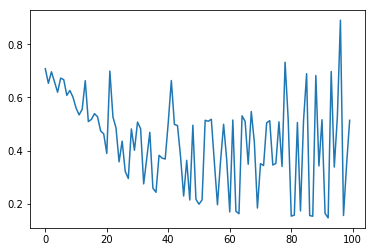

In [32]:
# plotting and diagnose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
showPlot(all_losses)

In [133]:
# validation/test
